# ESDA

Exploratory Spatial Data Analysis using PySal

Useful links: 

- http://pysal.org/notebooks/viz/splot/esda_morans_viz.html

- https://towardsdatascience.com/what-is-exploratory-spatial-data-analysis-esda-335da79026ee

- http://ljwolf.org/post/spatial_acf/

- Original LISA article: https://dces.webhosting.cals.wisc.edu/wp-content/uploads/sites/128/2013/08/W4_Anselin1995.pdf

Import libraries

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from libpysal.weights.contiguity import Queen
from esda.moran import Moran_Local,Moran_BV,Moran_Local_BV
from splot.esda import moran_scatterplot,plot_local_autocorrelation,lisa_cluster,plot_moran_bv
import geopandas as gpd
%matplotlib inline

Loading shp file for cities in Brazil

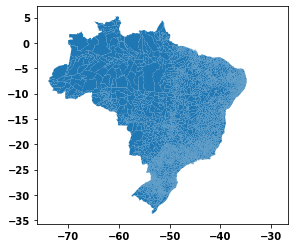

In [2]:
root = "../"
gdf = gpd.read_file(root + 'Maps/BRMUE250GC_SIR.shp')
gdf.plot()

## Spatial autocorrelation
Spatial autocorrelation describes the presence or absence of spacial variations in a given variable.

- Positive spatial autocorrelation: areas close to each other have similar values (High-high or Low-low)
- Negative spatial autocorrelation: neighbourhood areas are different from each other (Low-high or High-low) 

There are two types of spatial autocorrelation:

- Global: focuses on the overall trend in the dataset and gives us information about the degree of clustering 
- Local: detects variability and divergence in the dataset

Calculating contiguity weights (spacial similarity) with Queen.from_dataframe (http://darribas.org/gds_scipy16/ipynb_md/03_spatial_weights.html)

"Spatial similarity relation refers to similarity among and between objects on maps or in geographic space"
(source: https://www.sciencedirect.com/science/article/pii/S1674984715000191)

Spatial weights are how we determine the area’s neighborhood

In [3]:
w = Queen.from_dataframe(gdf)
w.transform = 'r'

('WARNING: ', 1773, ' is an island (no neighbors)')
('WARNING: ', 2170, ' is an island (no neighbors)')


C:\Users\marco\Anaconda3\lib\site-packages\libpysal\weights\weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 1773, 2170.
  warnings.warn(message)


In [32]:
w.pct_nonzero

0.10605148602204953

Taking a look at gdf 

In [4]:
gdf

,NM_MUNICIP,CD_GEOCMU,geometry
0,ABADIA DE GOIÃS,5200050,"POLYGON ((-49.44440 -16.71747, -49.44435 -16.7..."
1,ABADIA DOS DOURADOS,3100104,"POLYGON ((-47.43840 -18.16570, -47.43588 -18.1..."
2,ABADIÃNIA,5200100,"POLYGON ((-48.84178 -16.00488, -48.79639 -16.0..."
3,ABAETÃ,3100203,"POLYGON ((-45.16777 -18.89073, -45.16719 -18.8..."
4,ABAETETUBA,1500107,"POLYGON ((-48.83139 -1.56352, -48.82910 -1.571..."
...,...,...,...
5567,XIQUE-XIQUE,2933604,"POLYGON ((-42.38095 -10.24423, -42.37974 -10.2..."
5568,ZABELÃ,2517407,"POLYGON ((-37.14957 -8.02374, -37.14928 -8.024..."
5569,ZACARIAS,3557154,"POLYGON ((-49.99275 -21.03884, -49.99214 -21.0..."
5570,ZÃ DOCA,2114007,"POLYGON ((-45.92061 -3.02780, -45.91877 -3.028..."


CD_GEOCMU is the 7-digit city code, we need to convert it to the standard 6-digit code

In [5]:
cadmun = pd.read_csv(root + 'CSV/Cadmun/CADMUN.csv')
cadmun = cadmun[["MUNCOD", "MUNCODDV"]]
gdf["CD_GEOCMU"] = gdf["CD_GEOCMU"].astype(int)
gdf_city = pd.merge(gdf, cadmun, left_on="CD_GEOCMU", right_on="MUNCODDV", how="left")

In [6]:
gdf_city.head()

,NM_MUNICIP,CD_GEOCMU,geometry,MUNCOD,MUNCODDV
0,ABADIA DE GOIÃS,5200050,"POLYGON ((-49.44440 -16.71747, -49.44435 -16.7...",520005.0,5200050.0
1,ABADIA DOS DOURADOS,3100104,"POLYGON ((-47.43840 -18.16570, -47.43588 -18.1...",310010.0,3100104.0
2,ABADIÃNIA,5200100,"POLYGON ((-48.84178 -16.00488, -48.79639 -16.0...",520010.0,5200100.0
3,ABAETÃ,3100203,"POLYGON ((-45.16777 -18.89073, -45.16719 -18.8...",310020.0,3100203.0
4,ABAETETUBA,1500107,"POLYGON ((-48.83139 -1.56352, -48.82910 -1.571...",150010.0,1500107.0


Merging with suicide CSV to get SUICIDE_RATE for each city

In [7]:
suicide = pd.read_csv(root + 'CSV/Shrink/shrink_rates_08_18.csv', sep=',', index_col=0)
suicide['AVG_SUICIDE_RATE'] = np.mean(suicide.filter(regex=("RATE_*")), axis=1)
suicide.head()

,MUNCOD,RATE_08,RATE_09,RATE_10,RATE_11,RATE_12,RATE_13,RATE_14,RATE_15,RATE_16,RATE_17,RATE_18,AVG_SUICIDE_RATE
0,110001,8.137690,4.106102,4.094669,4.127456,4.154722,3.886816,3.898332,7.819220,7.841292,3.931281,4.316485,5.119460
1,110002,7.093792,7.014180,7.747305,9.828546,10.782020,7.899752,8.749757,9.578452,8.498905,18.631515,22.605682,10.766355
2,110003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.566625,15.735641,15.900779,32.133676,36.778227,10.555904
3,110004,6.388715,6.355259,8.905739,10.131841,7.563343,16.305044,17.329821,18.343155,20.483175,24.856791,29.476613,15.103591
4,110005,11.916111,12.032246,11.743981,11.807072,11.868028,11.085860,11.103092,11.119760,11.136478,11.152002,12.162491,11.557011


In [8]:
suicide = suicide[['MUNCOD', 'AVG_SUICIDE_RATE']]
result = pd.merge(gdf_city, suicide, left_on="MUNCOD", right_on="MUNCOD", how="left")
result = result[["NM_MUNICIP", "CD_GEOCMU", "geometry", "AVG_SUICIDE_RATE"]]
result['AVG_SUICIDE_RATE'] = result['AVG_SUICIDE_RATE'].fillna(0) #filling null values with 0

In [9]:
result.head(5)

,NM_MUNICIP,CD_GEOCMU,geometry,AVG_SUICIDE_RATE
0,ABADIA DE GOIÃS,5200050,"POLYGON ((-49.44440 -16.71747, -49.44435 -16.7...",9.337735
1,ABADIA DOS DOURADOS,3100104,"POLYGON ((-47.43840 -18.16570, -47.43588 -18.1...",33.053809
2,ABADIÃNIA,5200100,"POLYGON ((-48.84178 -16.00488, -48.79639 -16.0...",3.917704
3,ABAETÃ,3100203,"POLYGON ((-45.16777 -18.89073, -45.16719 -18.8...",21.483369
4,ABAETETUBA,1500107,"POLYGON ((-48.83139 -1.56352, -48.82910 -1.571...",4.199114


Defining the y dimension

In [10]:
y = result['AVG_SUICIDE_RATE'].values
y.shape

(5572,)

### Global spatial autocorrelation

Calculating Moran's I (measure of global spatial autocorrelation)

In [11]:
from esda.moran import Moran

moran = Moran(y, w)
moran.I

0.4151511677009573

In [33]:
?moran

Evaluating the significance:

In [21]:
print(moran.EI)
print(moran.p_norm)
print()
print(moran.EI_sim)
print(moran.p_sim)

-0.0001795009872554299
0.0

-0.0006112137264885236
0.001


We conclude that there is a **positive spatial autocorrelation** in this dataset, which is **significant** against the null hypothesis that attribute values are randomly distributed (p-value < 1%)

Visualizing the global spatial autocorrelation

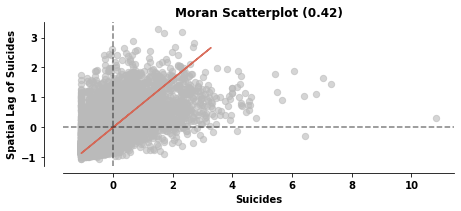

In [34]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
ax.set_xlabel('Suicides')
ax.set_ylabel('Spatial Lag of Suicides')
plt.show()

### Local spatial autocorrelation

Calculating Moran Local

In [13]:
moran_loc = Moran_Local(y, w)

C:\Users\marco\Anaconda3\lib\site-packages\esda\moran.py:886: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
C:\Users\marco\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\marco\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\marco\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


Plotting Moran's Local Scatter Plot

The scatter plot divides the areas into the four groups:
- High-high: top right
- High-low: bottom right
- Low-low: bottom left
- Low-high: top left


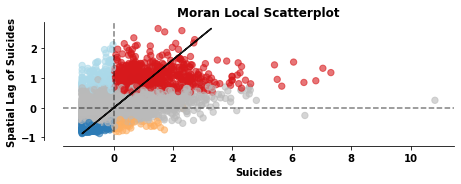

In [25]:
fig, ax = moran_scatterplot(moran_loc, p=0.05) # p: points colored by significance
ax.set_xlabel('Suicides')
ax.set_ylabel('Spatial Lag of Suicides')
plt.show()

Visualizing the clusters on a map

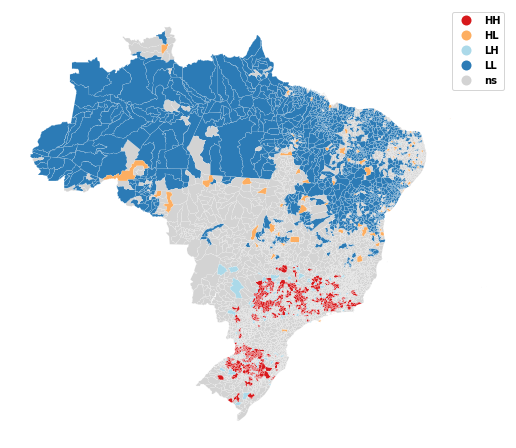

In [15]:
lisa_cluster(moran_loc, result, p=0.05, figsize=(9,9))
plt.show()

Combined visualizations 

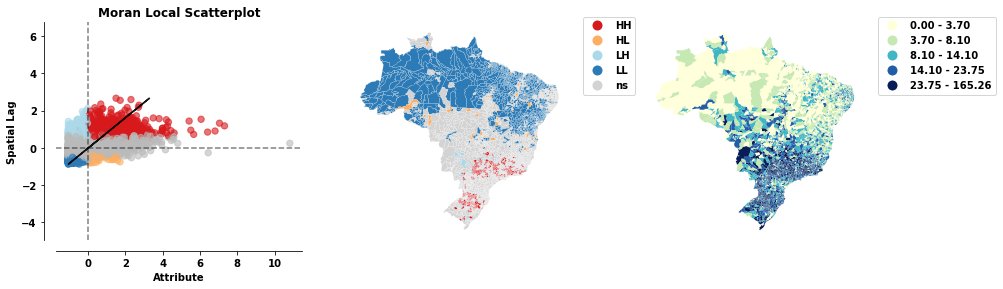

In [35]:
from splot.esda import plot_local_autocorrelation
plot_local_autocorrelation(moran_loc, result, 'AVG_SUICIDE_RATE')
plt.show()

Choropleth map of average suicide rates in Brazil (2008 - 2018)

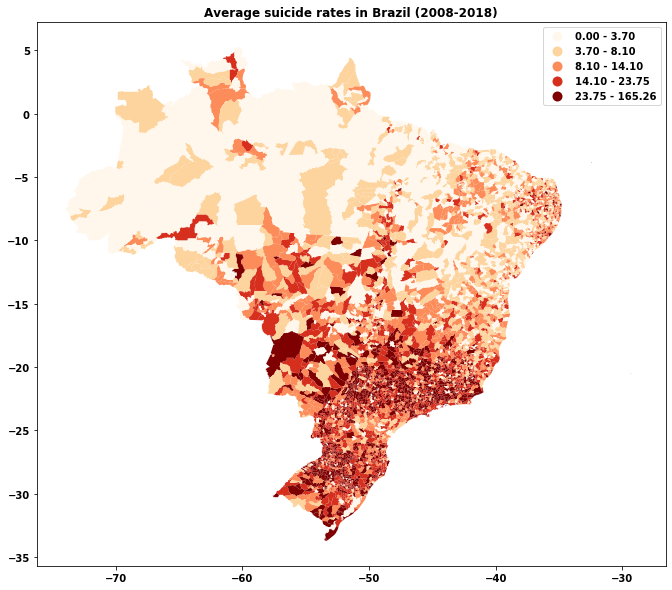

In [17]:
fig = result.plot(column='AVG_SUICIDE_RATE', legend=True, figsize=(15, 10), cmap='OrRd', scheme='quantiles')
plt.title("Average suicide rates in Brazil (2008-2018)")
plt.show()

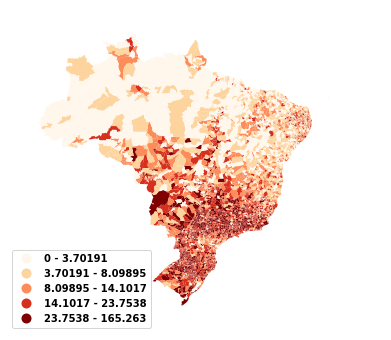

In [28]:
import geoplot as gplt
gplt.choropleth(result, hue='AVG_SUICIDE_RATE', cmap='OrRd', linewidth=0, scheme='quantiles', legend=True)

## Bivariate Moran Statistics

Inspecting the relationship of two variables and their position in space 

Loading disease data and merging with gdf

In [48]:
cancer = pd.read_csv(root + 'CSV/TabNet/Rates/CANCER_RATE_08_18.csv', sep=',', index_col=0)
cancer['AVG_CANCER_RATE'] = np.mean(cancer.filter(regex=("RATE_*")), axis=1)

In [49]:
cancer = cancer[['MUNCOD', 'AVG_CANCER_RATE']]
result = pd.merge(gdf_city, cancer, left_on="MUNCOD", right_on="MUNCOD", how="left")
result = pd.merge(result, suicide, left_on="MUNCOD", right_on="MUNCOD", how="left")
result = result[["NM_MUNICIP", "CD_GEOCMU", "geometry", "AVG_SUICIDE_RATE", 'AVG_CANCER_RATE']]
result['AVG_SUICIDE_RATE'] = result['AVG_SUICIDE_RATE'].fillna(0)
result['AVG_CANCER_RATE'] = result['AVG_CANCER_RATE'].fillna(0)

In [50]:
result.head()

,NM_MUNICIP,CD_GEOCMU,geometry,AVG_SUICIDE_RATE,AVG_CANCER_RATE
0,CACHOEIRA DO PIRIÁ,1501956,"POLYGON ((-46.31955 -1.75518, -46.31990 -1.755...",1.413653,21.518229
1,SÃO JOSÉ DOS BASÍLIOS,2111250,"POLYGON ((-44.63409 -5.03498, -44.63407 -5.034...",3.640247,128.563989
2,APARECIDA DO RIO DOCE,5201454,"POLYGON ((-51.14230 -18.29672, -51.14236 -18.2...",6.948837,179.777715
3,ARENÓPOLIS,5202353,"POLYGON ((-51.69953 -16.23270, -51.69957 -16.2...",7.759320,227.544794
4,CURUÁ,1502855,"POLYGON ((-55.17193 -1.83331, -55.16647 -1.731...",1.951002,37.104438


Bivariate Moran Statistics describe the correlation between one variable and the spatial lag of another variable
 
IMPORTANT: Bivariate Moran Statistics do not take the inherent correlation between the two variables at the same location into account.

In [51]:
x = result['AVG_SUICIDE_RATE'].values
y = result['AVG_CANCER_RATE'].values

Calculating Moran's BV I

A single statistic (and accompanying (p)-values computed using permutation methods) that relates the values of attribute (x) to the lag of (y).

In [52]:
moran_bv = Moran_BV(y, x, w)
moran_bv.I

0.37266897231590945

Plotting Moran BV

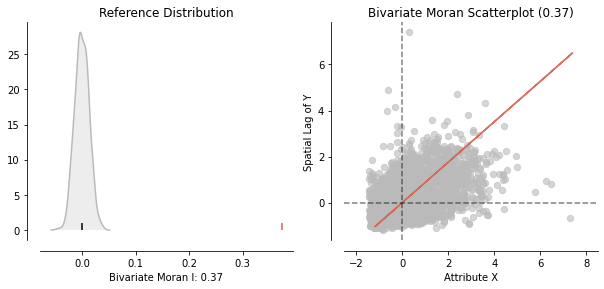

In [53]:
plot_moran_bv(moran_bv)
plt.show()

Calculating BV Moran Local

C:\Users\pypas\anaconda3\envs\ML\lib\site-packages\esda\moran.py:1121: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
C:\Users\pypas\anaconda3\envs\ML\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\pypas\anaconda3\envs\ML\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\pypas\anaconda3\envs\ML\lib\site-packages\scipy\stats\_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


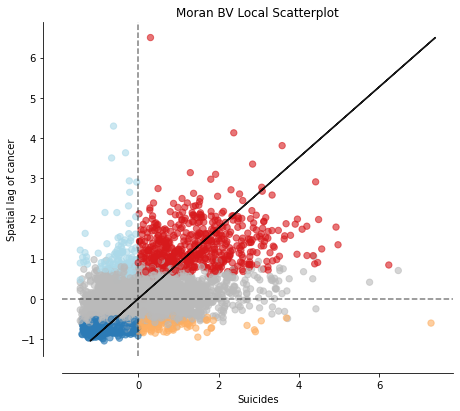

In [54]:
moran_loc_bv = Moran_Local_BV(y, x, w)
fig, ax = moran_scatterplot(moran_loc_bv, p=0.05)
ax.set_xlabel('Suicides')
ax.set_ylabel('Spatial lag of cancer')
plt.show()

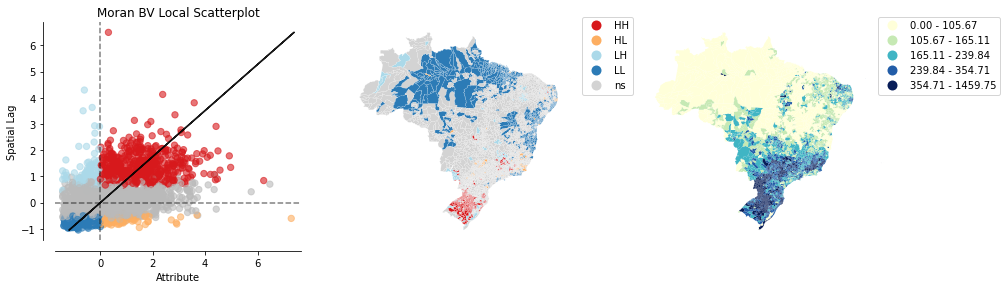

In [55]:
plot_local_autocorrelation(moran_loc_bv, result, 'AVG_CANCER_RATE')
plt.show()

## Table of Moran BV I (Suicide vs. Disease)

Let's see the Moran BV I value for each disease:

In [56]:
import glob
import re

In [57]:
path = root + "CSV/TabNet/Rates/"
all_files = glob.glob(path + "*.csv")

In [58]:
morans = []
diseases = []
for file in all_files:
    # disease name
    disease = file
    disease = disease.split('\\')[1].split('_RATE')[0]
    # read file
    rates = pd.read_csv(file.replace('\\', '/'), sep=',', index_col=0)
    # calculate average
    rates['AVG_DISEASE_RATE'] = np.mean(rates.filter(regex=("RATE_*")), axis=1)
    # merges with suicide and gdf
    rates = rates[['MUNCOD', 'AVG_DISEASE_RATE']]
    result = pd.merge(gdf_city, rates, left_on="MUNCOD", right_on="MUNCOD", how="left")
    result = pd.merge(result, suicide, left_on="MUNCOD", right_on="MUNCOD", how="left")
    result = result[["NM_MUNICIP", "CD_GEOCMU", "geometry", "AVG_SUICIDE_RATE", 'AVG_DISEASE_RATE']]
    # fill NaN's with 0
    result['AVG_SUICIDE_RATE'] = result['AVG_SUICIDE_RATE'].fillna(0)
    result['AVG_DISEASE_RATE'] = result['AVG_DISEASE_RATE'].fillna(0)

    x = result['AVG_SUICIDE_RATE'].values
    y = result['AVG_DISEASE_RATE'].values

    moran_bv = Moran_BV(y, x, w)
    
    diseases.append(disease)
    morans.append(moran_bv.I)

In [59]:
morans_data = {'Doenças': diseases, 'Moran BV I': morans}
morans_data = pd.DataFrame(data=morans_data)
morans_data.sort_values(by=['Moran BV I'], ascending=False)

,Doenças,Moran BV I
1,CANCER,0.372669
6,DPOC,0.318841
16,TRANSTORNOS_MENTAIS,0.317439
14,OSTEOPOROSE,0.249833
15,TECIDO_MOLE,0.238202
3,DOENCA_CARDIACA,0.222750
13,INSUFICIENCIA_RENAL,0.187766
4,DOENCA_DE_PARKINSON,0.181546
12,INSUFICIENCIA_CARDIACA,0.161100
9,ESCLEROSE_MULTIPLA,0.129413
